# 01 - Préparation et Exploration des Données

Ce notebook effectue la **préparation complète** des données pour le projet de scoring de crédit.

## Objectifs

1. **Chargement et fusion** des 8 tables CSV (application, bureau, previous_application, etc.)
2. **Nettoyage** des données (anomalies, doublons, valeurs manquantes)
3. **Feature Engineering** (ratios financiers, agrégations multi-niveaux)
4. **Encodage** des variables catégorielles (Label Encoding + One-Hot)
5. **Analyse exploratoire** :
   - Déséquilibre des classes
   - Valeurs manquantes
   - Validation de l'intégrité des données
6. **Sauvegarde** des datasets finaux prêts pour l'entraînement

> **Note :** Ce notebook utilise la fonction `load_and_process_all_data()` du module `src/data_prep.py` qui orchestre la fusion, le nettoyage et l'enrichissement.


In [5]:
# ============================================================================
# IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import os
import warnings
import gc
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
# Imports des fonctions personnalisées
from data_prep import load_and_process_all_data, missing_values_table

# Configuration d'affichage
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")


## 1. Chargement et Fusion des Données

La fonction `load_and_process_all_data()` effectue automatiquement :
1. **Chargement** des 8 tables CSV (application_train, application_test, bureau, bureau_balance, previous_application, POS_CASH_balance, installments_payments, credit_card_balance)
2. **Nettoyage** des anomalies (ex: `DAYS_EMPLOYED = 365243` → NaN + flag)
3. **Feature Engineering** :
   - Création de 4 ratios financiers (CREDIT_INCOME_PERCENT, ANNUITY_INCOME_PERCENT, CREDIT_TERM, DAYS_EMPLOYED_PERCENT)
   - Agrégations multi-niveaux depuis les tables auxiliaires
4. **Encodage** des variables catégorielles (Label Encoding pour binaires, One-Hot pour les autres)
5. **Alignement** final des sets Train/Test (même colonnes)


In [6]:
# ============================================================================
# CHARGEMENT ET FUSION DES DONNÉES
# ============================================================================

# Configuration du chemin vers les datasets (relatif au dossier notebooks/)
DATASETS_PATH = 'datasets'

print("🚀 Démarrage du processus de fusion et enrichissement...")
print("   Cette étape peut prendre plusieurs minutes selon la taille des données.\n")

# Lancement de la fonction maîtresse qui orchestre toutes les étapes
df_train, df_test = load_and_process_all_data(DATASETS_PATH)

# Nettoyage de la mémoire après l'étape de fusion intensive
gc.collect()

print("\n✅ Fusion et enrichissement terminés avec succès !")

🚀 Démarrage du processus de fusion et enrichissement...
   Cette étape peut prendre plusieurs minutes selon la taille des données.

Chargement de application_train...
Mémoire réduite: 286.23 MB -> 128.16 MB (55.2% gain)
Chargement de application_test...
Mémoire réduite: 45.00 MB -> 20.27 MB (55.0% gain)

--- Traitement Bureau & Balance ---
Chargement de bureau...
Mémoire réduite: 222.62 MB -> 119.49 MB (46.3% gain)
Chargement de bureau_balance...
Mémoire réduite: 624.85 MB -> 338.46 MB (45.8% gain)

--- Traitement Previous Application ---
Chargement de previous_application...
Mémoire réduite: 471.48 MB -> 324.94 MB (31.1% gain)

--- Traitement POS_CASH ---
Chargement de POS_CASH_balance...
Mémoire réduite: 610.43 MB -> 276.60 MB (54.7% gain)
Mémoire réduite: 273.24 MB -> 120.55 MB (55.9% gain)

--- Traitement Installments ---
Chargement de installments_payments...
Mémoire réduite: 830.41 MB -> 389.25 MB (53.1% gain)
Mémoire réduite: 171.28 MB -> 119.89 MB (30.0% gain)

--- Traitement C

## 2. Validation de l'Intégrité des Données

Vérification de la cohérence des jeux de données pour s'assurer qu'il n'y a pas eu de pertes ou duplications inattendues lors des fusions.


In [7]:
# ============================================================================
# VÉRIFICATION DE L'INTÉGRITÉ
# ============================================================================

print(f"📊 Shape final du Train : {df_train.shape}")
print(f"   Nombre de IDs uniques (Train) : {df_train['SK_ID_CURR'].nunique()}")
print(f"\n📊 Shape final du Test : {df_test.shape}")
print(f"   Nombre de IDs uniques (Test) : {df_test['SK_ID_CURR'].nunique()}")

# Vérification des colonnes communes (doivent être les mêmes grâce à l'alignement)
train_cols = set(df_train.drop(columns=['TARGET', 'SK_ID_CURR']).columns)
test_cols = set(df_test.drop(columns=['SK_ID_CURR']).columns)

print(f"\n📈 Nombre de features après FE/Encodage : {len(train_cols)}")

if train_cols == test_cols:
    print("✅ Succès : Les jeux d'entraînement et de test sont alignés.")
else:
    print("⚠️  Alerte : Les colonnes ne correspondent pas.")
    print(f"   Colonnes manquantes dans test : {train_cols - test_cols}")
    print(f"   Colonnes en trop dans test : {test_cols - train_cols}")

📊 Shape final du Train : (307511, 1847)
   Nombre de IDs uniques (Train) : 307511

📊 Shape final du Test : (48744, 1846)
   Nombre de IDs uniques (Test) : 48744

📈 Nombre de features après FE/Encodage : 1845
✅ Succès : Les jeux d'entraînement et de test sont alignés.


## 3. Analyse du Déséquilibre des Classes

La variable cible `TARGET` indique si le client a eu des difficultés de paiement :
- **0** : Prêt remboursé sans problème
- **1** : Difficultés de paiement (défaut)

Le déséquilibre des classes est un **enjeu métier majeur** à intégrer dans la construction du modèle.


📊 Distribution de la variable TARGET :

Classe     Nombre          Pourcentage    
----------------------------------------
0          282686          91.93%
1          24825           8.07%

Le dataset est fortement déséquilibré :
   - Classe majoritaire (0) : 91.93%
   - Classe minoritaire (1) : 8.07%
   - Ratio : 11.4:1


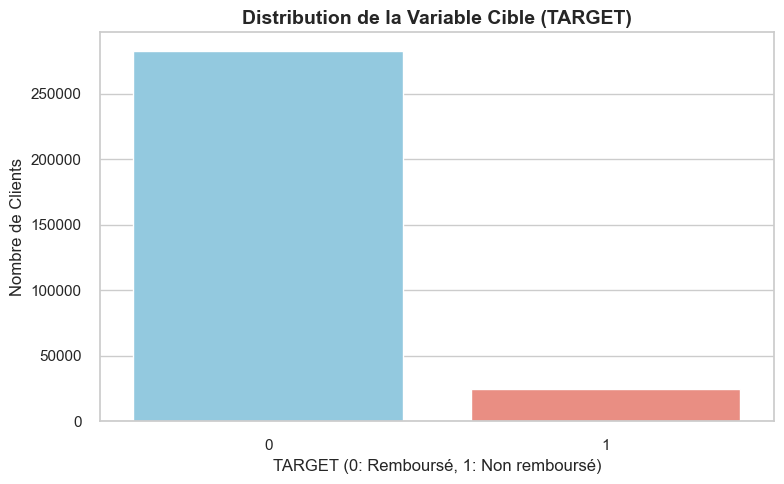

In [10]:
# ============================================================================
# DISTRIBUTION DE LA VARIABLE CIBLE
# ============================================================================

target_counts = df_train['TARGET'].value_counts()
target_percentages = df_train['TARGET'].value_counts(normalize=True) * 100

print("📊 Distribution de la variable TARGET :")
print(f"\n{'Classe':<10} {'Nombre':<15} {'Pourcentage':<15}")
print("-" * 40)
for idx in [0, 1]:
    print(f"{idx:<10} {target_counts[idx]:<15} {target_percentages[idx]:.2f}%")

print(f"\nLe dataset est fortement déséquilibré :")
print(f"   - Classe majoritaire (0) : {target_percentages[0]:.2f}%")
print(f"   - Classe minoritaire (1) : {target_percentages[1]:.2f}%")
print(f"   - Ratio : {target_counts[0] / target_counts[1]:.1f}:1")

# Visualisation
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df_train, x='TARGET', palette=['skyblue', 'salmon'], ax=ax)
ax.set_title('Distribution de la Variable Cible (TARGET)', fontsize=14, fontweight='bold')
ax.set_xlabel('TARGET (0: Remboursé, 1: Non remboursé)', fontsize=12)
ax.set_ylabel('Nombre de Clients', fontsize=12)


plt.tight_layout()
plt.show()

### Implications du déséquilibre

Le dataset est **fortement déséquilibré** (~92% de classe 0, ~8% de classe 1). Cela nécessite :

1. **Techniques d'entraînement adaptées** :
   - Utilisation de `class_weight='balanced'` dans les modèles
   - Métriques adaptées (F1-score, AUC-ROC, coût métier)
   - Optimisation du seuil de décision (pas 0.5 par défaut)

2. **Métrique métier** :
   - Le coût d'un **Faux Négatif** (FN) est 10× plus élevé qu'un **Faux Positif** (FP)
   - Il faut minimiser les FN (ne pas manquer les vrais défauts)


## 4. Analyse des Valeurs Manquantes

Analyse de l'étendue des valeurs manquantes introduites par le processus d'enrichissement (agrégations depuis les tables auxiliaires).


In [11]:
# ============================================================================
# ANALYSE DES VALEURS MANQUANTES
# ============================================================================

missing_table = missing_values_table(df_train)

print(f"📊 Colonnes avec des valeurs manquantes : {len(missing_table)} sur {len(df_train.columns)}")
print(f"\nTop 20 des colonnes avec le plus de valeurs manquantes :\n")
print(missing_table.head(20).to_string())

# Résumé statistique
if len(missing_table) > 0:
    print(f"\n📈 Statistiques sur les valeurs manquantes :")
    print(f"   - Pourcentage moyen : {missing_table['% of Total Values'].mean():.2f}%")
    print(f"   - Pourcentage maximum : {missing_table['% of Total Values'].max():.2f}%")
    print(f"   - Colonnes avec >50% de valeurs manquantes : {(missing_table['% of Total Values'] > 50).sum()}")

📊 Colonnes avec des valeurs manquantes : 1667 sur 1847

Top 20 des colonnes avec le plus de valeurs manquantes :

                                                        Missing Values  % of Total Values
prev_agg_RATE_INTEREST_PRIMARY_mean                             302902               98.5
prev_agg_RATE_INTEREST_PRIMARY_max                              302902               98.5
prev_agg_RATE_INTEREST_PRIMARY_min                              302902               98.5
prev_agg_RATE_INTEREST_PRIVILEGED_mean                          302902               98.5
prev_agg_RATE_INTEREST_PRIVILEGED_max                           302902               98.5
prev_agg_RATE_INTEREST_PRIVILEGED_min                           302902               98.5
client_credit_credit_AMT_PAYMENT_CURRENT_min_mean               246451               80.1
client_credit_credit_AMT_PAYMENT_CURRENT_min_min                246451               80.1
client_credit_credit_AMT_PAYMENT_CURRENT_mean_min               246451      

### Stratégie d'Imputation

De nombreuses *features* agrégées (issues des fusions avec des tables peu remplies pour certains clients) présentent un taux élevé de valeurs manquantes.

**Stratégie :** Nous **ne procédons à aucune imputation** pour l'instant.

**Justification :** L'utilisation de modèles *tree-based* (comme LightGBM ou XGBoost) est prévue. Ces algorithmes gèrent nativement les `NaN` et peuvent les utiliser comme un indicateur de l'absence d'historique. Cela permet de **préserver l'information** et répond à l'exigence d'éviter d'**imputer sans documenter ni justifier**.


## 5. Validation des Features Créées

Vérification de la création et de la corrélation des *features* de *Domain Knowledge* (Feature Engineering manuel) créées à partir de la table `application`.


In [13]:
# ============================================================================
# VALIDATION DES RATIOS FINANCIERS
# ============================================================================

# Identifier les features créées manuellement (ratios)
new_features_ratios = [
    'CREDIT_INCOME_PERCENT', 
    'ANNUITY_INCOME_PERCENT', 
    'CREDIT_TERM', 
    'DAYS_EMPLOYED_PERCENT',
    'DAYS_EMPLOYED_ANOM'  # Le flag d'anomalie
]

# Vérifier qu'elles existent et calculer les corrélations avec TARGET
existing_ratios = [f for f in new_features_ratios if f in df_train.columns]

if existing_ratios:
    correlation_df = df_train[existing_ratios + ['TARGET']].copy()
    correlation_ratios = correlation_df.corr().sort_values('TARGET', ascending=False)
    
    print("📊 Corrélations des features de ratios avec TARGET :")
    print(correlation_ratios['TARGET'].drop('TARGET').to_string())
    
    print(f"\n✅ {len(existing_ratios)} features de ratios créées avec succès")
else:
    print("Aucune feature de ratio trouvée") 

📊 Corrélations des features de ratios avec TARGET :
DAYS_EMPLOYED_PERCENT     0.067955
ANNUITY_INCOME_PERCENT    0.014265
CREDIT_TERM               0.012704
CREDIT_INCOME_PERCENT    -0.007727
DAYS_EMPLOYED_ANOM       -0.045987

✅ 5 features de ratios créées avec succès


### Conclusion sur les Ratios

Les ratios ont des corrélations faibles à modérées avec TARGET. Ces corrélations sont souvent plus fortes que celles de nombreuses *features* initiales et justifient leur conservation et leur évaluation par le modèle.



## 6. Aperçu du Dataset Final

Affichage d'un aperçu du dataset enrichi pour validation.


## 7. Sauvegarde des Datasets Finaux

Sauvegarde des datasets enrichis et alignés dans le dossier `datasets/final/` pour utilisation dans les notebooks suivants.


In [12]:
# ============================================================================
# SAUVEGARDE DES DATASETS
# ============================================================================

# Créer le dossier de destination s'il n'existe pas
os.makedirs('../datasets/final', exist_ok=True)

# Séparer les IDs et labels avant la sauvegarde
train_ids = df_train['SK_ID_CURR']
train_labels = df_train['TARGET']
df_train_final = df_train.drop(columns=['SK_ID_CURR', 'TARGET'])

test_ids = df_test['SK_ID_CURR']
df_test_final = df_test.drop(columns=['SK_ID_CURR'])

# Sauvegarde des datasets enrichis (sans SK_ID_CURR ni TARGET)
df_train_final.to_csv('../datasets/final/train_enriched.csv', index=False)
df_test_final.to_csv('../datasets/final/test_enriched.csv', index=False)

# Sauvegarde des IDs et labels séparément pour la gestion du pipeline MLOps
train_labels.to_csv('../datasets/final/train_labels.csv', index=False, header=True)
train_ids.to_csv('../datasets/final/train_ids.csv', index=False, header=True)
test_ids.to_csv('../datasets/final/test_ids.csv', index=False, header=True)

print("✅ Datasets enrichis et alignés sauvegardés dans 'datasets/final/' :")
print("   - train_enriched.csv : Features d'entraînement")
print("   - test_enriched.csv : Features de test")
print("   - train_labels.csv : Labels d'entraînement (TARGET)")
print("   - train_ids.csv : IDs d'entraînement (SK_ID_CURR)")
print("   - test_ids.csv : IDs de test (SK_ID_CURR)")

print("\n📊 Résumé final :")
print(f"   - Features : {df_train_final.shape[1]} colonnes")
print(f"   - Échantillons train : {df_train_final.shape[0]}")
print(f"   - Échantillons test : {df_test_final.shape[0]}")


✅ Datasets enrichis et alignés sauvegardés dans 'datasets/final/' :
   - train_enriched.csv : Features d'entraînement
   - test_enriched.csv : Features de test
   - train_labels.csv : Labels d'entraînement (TARGET)
   - train_ids.csv : IDs d'entraînement (SK_ID_CURR)
   - test_ids.csv : IDs de test (SK_ID_CURR)

📊 Résumé final :
   - Features : 1845 colonnes
   - Échantillons train : 307511
   - Échantillons test : 48744


---

## Prochaine Étape

Le dataset enrichi est prêt pour l'entraînement. 

➡️ **Notebook suivant :** `02_model_training.ipynb` - Modélisation et tracking des expérimentations avec MLflow
